<a href="https://colab.research.google.com/github/Bag0niku/Neural_Network_Charity_Analysis/blob/main/Charity_Funding_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the Environment

In [ ]:
# %matplotlib
# Import our dependencies
!pip install keras-tuner
import kerastuner as kt

import pandas as pd
import matplotlib as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import os

filepath = "https://nn-charity-analysis.s3.us-west-2.amazonaws.com/charity_data.csv"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import and clean the data for use in the Neural Network Model

The training and testing data needs to be numeric and scaled. 

In [ ]:
# Import the data into a dataframe
df = pd.read_csv(filepath)
df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [ ]:
# Look for null values and incorrect datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EIN                     34299 non-null  int64 
 1   NAME                    34299 non-null  object
 2   APPLICATION_TYPE        34299 non-null  object
 3   AFFILIATION             34299 non-null  object
 4   CLASSIFICATION          34299 non-null  object
 5   USE_CASE                34299 non-null  object
 6   ORGANIZATION            34299 non-null  object
 7   STATUS                  34299 non-null  int64 
 8   INCOME_AMT              34299 non-null  object
 9   SPECIAL_CONSIDERATIONS  34299 non-null  object
 10  ASK_AMT                 34299 non-null  int64 
 11  IS_SUCCESSFUL           34299 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 3.1+ MB


In [ ]:
# Count the number of unique values in each column.
df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

Currently have:

Features: 
*   APPLICATION_TYPE (Categorical string)
*   AFFILIATION      (Categorical string)
*   CLASSIFICATION   (Categorical string)
*   USE_CASE         (Categorical string)
*   ORGANIZATION     (Categorical string)
*   STATUS           (Numeric T/F)
*   INCOME_AMT       (Categorical string)
*   SPECIAL_CONSIDERATIONS (Numeric T/F)
*   ASK_AMT          (Number)

Target: 
*   IS_SUCCESSFUL    (Numeric T/F)


What we want the neural network to process all the features as numeric T/F columns, including the categorical strings, this technique is also known as One Hot Encoding.

In [ ]:
# start with minimize "Classification" to a veriety of 10 categories, not 71.
class_df = pd.DataFrame(df["CLASSIFICATION"].value_counts())
class_df["CLASSIFICATION"].sort_values(ascending=False).head(10)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
Name: CLASSIFICATION, dtype: int64

In [ ]:
# keep the top 9 calssifications and change the rest to "OTHER", totaling 10 categories
class_categories = class_df[class_df["CLASSIFICATION"] >115].index.to_list()
class_changing = int(class_df[class_df['CLASSIFICATION'] < 115]["CLASSIFICATION"].sum())
n_total = int(class_df['CLASSIFICATION'].sum())
print(f"CLASSIFICATION records being converted to 'OTHER': {class_changing} is {round((class_changing/n_total)*100, 2)}% of the total records")


CLASSIFICATION records being converted to 'OTHER': 887 is 2.59% of the total records


In [ ]:
df["APPLICATION_TYPE"].value_counts().sort_values(ascending=False).head(10)

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
Name: APPLICATION_TYPE, dtype: int64

In [ ]:
# keep the top 9 App types and change the rest to "OTHER", totaling 10 categories
app_type_df = pd.DataFrame(df["APPLICATION_TYPE"].value_counts().sort_values(ascending=False))
app_types = app_type_df[app_type_df["APPLICATION_TYPE"]>100].index.to_list()
app_changing = int(app_type_df[app_type_df["APPLICATION_TYPE"] < 100].sum())
print(f"APPLICATION_TYPE records being converted to 'OTHER': {app_changing} is {round((app_changing/n_total)*100, 2)}% of the total records")


APPLICATION_TYPE records being converted to 'OTHER': 120 is 0.35% of the total records


In [ ]:
# apply changes to the data using a new dataframe, so the original remains untouched
# if required to be used or modified in a different way
df2 = df.copy()
df2["APPLICATION_TYPE"] = df2["APPLICATION_TYPE"].apply(lambda x: x if x in app_types else "OTHER")
df2["CLASSIFICATION"] = df2["CLASSIFICATION"].apply(lambda x: x if x in class_categories else "OTHER")
df2["SPECIAL_CONSIDERATIONS"] = df2["SPECIAL_CONSIDERATIONS"] == 'Y'  ## converts Y/N to True/False, computer will see as 1/0
df2["STATUS"].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

In [ ]:
#  Transform the string categories into T/F numerical columns representing each category.
# "APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "SPECIAL_CONSIDERATIONS", "INCOME_AMT"
one_hot_encoded_df = pd.get_dummies(df2, columns=["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT"])

# Name and EIN will be removed for the computation, they will not help
# the machine weigh options and metrics, and IS_SUCCESSFULL is our goal.
encoded_df = one_hot_encoded_df.drop(["EIN", "NAME", "IS_SUCCESSFUL"], axis=1)
encoded_df

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,APPLICATION_TYPE_OTHER,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,1,False,5000,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,False,108590,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,False,5000,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,False,6692,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,1,False,142590,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,1,False,5000,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
34295,1,False,5000,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
34296,1,False,5000,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
34297,1,False,5000,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Checking the status of the data
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   STATUS                        34299 non-null  int64
 1   SPECIAL_CONSIDERATIONS        34299 non-null  bool 
 2   ASK_AMT                       34299 non-null  int64
 3   APPLICATION_TYPE_OTHER        34299 non-null  uint8
 4   APPLICATION_TYPE_T10          34299 non-null  uint8
 5   APPLICATION_TYPE_T19          34299 non-null  uint8
 6   APPLICATION_TYPE_T3           34299 non-null  uint8
 7   APPLICATION_TYPE_T4           34299 non-null  uint8
 8   APPLICATION_TYPE_T5           34299 non-null  uint8
 9   APPLICATION_TYPE_T6           34299 non-null  uint8
 10  APPLICATION_TYPE_T7           34299 non-null  uint8
 11  APPLICATION_TYPE_T8           34299 non-null  uint8
 12  APPLICATION_TYPE_T9           34299 non-null  uint8
 13  AFFILIATION_CompanySponsored  3

In [ ]:
encoded_df = encoded_df.astype(float)
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34299 entries, 0 to 34298
Data columns (total 47 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   STATUS                        34299 non-null  float64
 1   SPECIAL_CONSIDERATIONS        34299 non-null  float64
 2   ASK_AMT                       34299 non-null  float64
 3   APPLICATION_TYPE_OTHER        34299 non-null  float64
 4   APPLICATION_TYPE_T10          34299 non-null  float64
 5   APPLICATION_TYPE_T19          34299 non-null  float64
 6   APPLICATION_TYPE_T3           34299 non-null  float64
 7   APPLICATION_TYPE_T4           34299 non-null  float64
 8   APPLICATION_TYPE_T5           34299 non-null  float64
 9   APPLICATION_TYPE_T6           34299 non-null  float64
 10  APPLICATION_TYPE_T7           34299 non-null  float64
 11  APPLICATION_TYPE_T8           34299 non-null  float64
 12  APPLICATION_TYPE_T9           34299 non-null  float64
 13  A

In [ ]:
# does the data need scaled?
encoded_df.describe()

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,APPLICATION_TYPE_OTHER,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
count,34299.000000,34299.000000,3.429900e+04,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,...,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000
mean,0.999854,0.000787,2.769199e+06,0.003499,0.015394,0.031050,0.788274,0.044958,0.034199,0.035453,...,0.685589,0.711041,0.021225,0.015831,0.098370,0.006997,0.027843,0.109245,0.004053,0.005394
std,0.012073,0.028046,8.713045e+07,0.059047,0.123116,0.173457,0.408538,0.207214,0.181743,0.184924,...,0.464288,0.453285,0.144136,0.124825,0.297819,0.083358,0.164526,0.311951,0.063532,0.073245
min,0.000000,0.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,5.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,5.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,7.742000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,8.597806e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
## scale the data
std_scaled_df = pd.DataFrame(StandardScaler().fit_transform(encoded_df), index=encoded_df.index, columns=encoded_df.columns)
std_scaled_df

,STATUS,SPECIAL_CONSIDERATIONS,ASK_AMT,APPLICATION_TYPE_OTHER,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.012075,-0.028068,-0.031725,-0.059253,7.997514,-0.179013,-1.929528,-0.216965,-0.188176,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
1,0.012075,-0.028068,-0.030536,-0.059253,-0.125039,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,...,-1.476667,-1.568662,6.79073,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
2,0.012075,-0.028068,-0.031725,-0.059253,-0.125039,-0.179013,-1.929528,-0.216965,5.314171,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
3,0.012075,-0.028068,-0.031706,-0.059253,-0.125039,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,...,0.677201,-1.568662,-0.14726,7.884526,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
4,0.012075,-0.028068,-0.030146,-0.059253,-0.125039,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,...,0.677201,-1.568662,-0.14726,-0.126831,3.027487,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,0.012075,-0.028068,-0.031725,-0.059253,-0.125039,-0.179013,-1.929528,4.609034,-0.188176,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
34295,0.012075,-0.028068,-0.031725,-0.059253,-0.125039,-0.179013,-1.929528,4.609034,-0.188176,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
34296,0.012075,-0.028068,-0.031725,-0.059253,-0.125039,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641
34297,0.012075,-0.028068,-0.031725,-0.059253,-0.125039,-0.179013,-1.929528,-0.216965,5.314171,-0.191719,...,-1.476667,0.637486,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641


In [ ]:
## test_train_split the data
X_train, X_test, y_train, y_test = train_test_split(std_scaled_df, df["IS_SUCCESSFUL"])


In [ ]:
# total number of input dimensions
input_dims = len(std_scaled_df.columns)
input_dims

47

# Build The Neural Network Model

The model will start with 3 hidden layers and one known output layer. After some testing of the model, making adjustments 

The nodes on the hidden layers will be based on the number of inputs and all use the "tanh" activation equation.

*   Hidden Layer one: input*1.25
*   Hidden Layer two: input*1.75
*   Hidden Layer three: input/2



In [ ]:
## directory for storing the checkpoints generated by the nn model
os.makedirs(os.path.join("checkpoints"), exist_ok=True)
checkpoint_filepath = os.path.join("checkpoints", "weights.{epoch:02d}.hdf5")

In [ ]:
## Create the checkpoint function to save the weights
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=True, save_freq="epoch")

In [ ]:
## The Meat of the Neural Network Model
keras_model = tf.keras.models.Sequential()

## Hidden Layers
keras_model.add(tf.keras.layers.Dense(units=int(input_dims*1.25), activation="tanh", input_dim=input_dims))  ## input and hidden layer 1
keras_model.add(tf.keras.layers.Dense(units=int(input_dims*1.75), activation="tanh"))  ## hidden layer 2
keras_model.add(tf.keras.layers.Dense(units=int(input_dims/2), activation="tanh"))  ## hidden layer 3

## This is the known output layer, 
## we want only T/F statements, that is why sigmoid was chosen.
keras_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 58)                2784      
                                                                 
 dense_1 (Dense)             (None, 82)                4838      
                                                                 
 dense_2 (Dense)             (None, 23)                1909      
                                                                 
 dense_3 (Dense)             (None, 1)                 24        
                                                                 
Total params: 9,555
Trainable params: 9,555
Non-trainable params: 0
_________________________________________________________________


In [ ]:
keras_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
fitted_model = keras_model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
799/804 [============================>.] - ETA: 0s - loss: 0.5683 - accuracy: 0.7209
Epoch 1: saving model to checkpoints/weights.01.hdf5
804/804 [==============================] - 2s 1ms/step - loss: 0.5683 - accuracy: 0.7208
Epoch 2/100
798/804 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.7300
Epoch 2: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5551 - accuracy: 0.7296
Epoch 3/100
799/804 [============================>.] - ETA: 0s - loss: 0.5499 - accuracy: 0.7305
Epoch 3: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5502 - accuracy: 0.7303
Epoch 4/100
795/804 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.7304
Epoch 4: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5485 - accuracy: 0.7308
Epoch 5/100
788/804 [=======================

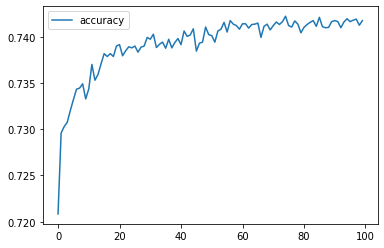

In [ ]:
# from pandas.plotting import boxplot
fitted_df = pd.DataFrame(fitted_model.history)
fitted_df.plot(y="accuracy", kind="line")

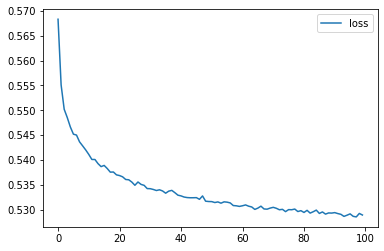

In [ ]:
fitted_df.plot(y="loss", kind='line')

In [ ]:
# nn_model.evaluate(X_test, y_test)
model_loss, model_accuracy = keras_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


268/268 - 0s - loss: 0.5610 - accuracy: 0.7287 - 324ms/epoch - 1ms/step
Loss: 0.5609843730926514, Accuracy: 0.7287463545799255


# Find an Optimized version of the Neural Network Model.

The goal at this point is to be at or above 75% accuracy, the model at this point provides 72.87% accuracy with the testing data. This will be attempted in a seperate ipynb notebook.

*   The first attemt to optimize the model will be to use the Keras Tuner to find the best number of hidden layers and neurons.
   *    Minimum number of hidden layers: 2
   *    Maximum number of hidden layers: 6  
   *    Minimum number of neurons per layer: 1
   *    Maximum number of neurons per layer: input_dims * 1.75 
   *    Test the top 3 models the Keras Tuner finds and train them again with 500 epochs before evaluating them with the test data.
*   The second attempt will be to adjust the Keras Tuner for the ability to have multiple activation equations in the hidden layers.

